# Data Analysis

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import joblib
import os

This project follows the CRISP-DM methodology (Cross Industry Standard Process for Data Mining) to conduct a comprehensive data analysis using the FoodData Central Foundation Food dataset. The goal is to understand the nutritional composition of foods, identify the most common nutrients, and explore patterns across food categories.

## Introduction
The main objective is to derive insights from nutritional data that can support dietary studies, food labeling, and energy estimation. Key business questions include:

- What are the most common nutrients in the database?
- How do nutrient profiles vary across different food categories?
- Which nutrients contribute the most to total energy content?

## Data Understanding

The analysis uses several CSV files from the FoodData Central database, including foods, food categories, nutrients, food-nutrient relationships, and conversion factors for macronutrients. The data provides detailed nutritional values and metadata for a wide range of food items.

### Loading data

In [95]:
folder = 'data/raw'
# Read all relevant CSVs as string columns

foods = pd.read_csv(os.path.join(folder, 'food.csv'), dtype=str)
category = pd.read_csv(os.path.join(folder, 'food_category.csv'), dtype=str)

nutrients = pd.read_csv(os.path.join(folder, 'nutrient.csv'), dtype=str)
food_nutrients = pd.read_csv(os.path.join(folder, 'food_nutrient.csv'), dtype=str)

food_nutrient_conversion_factor = pd.read_csv(os.path.join(folder, 'food_nutrient_conversion_factor.csv'), dtype=str)
calorie_factor = pd.read_csv(os.path.join(folder, 'food_calorie_conversion_factor.csv'), dtype=str)

### Data Transformations

In [96]:
# Data preparation: renaming columns and converting data types
nutrients = nutrients.rename(
    columns={'id': 'nutrient_id', 'name': 'nutrient_name'}
)

category = category.rename(
    columns={'id': 'food_category_id', 'description': 'food_category'}
)

food_nutrient_conversion_factor = food_nutrient_conversion_factor.rename(
    columns={'id': 'food_nutrient_conversion_factor_id'}
)

foods = foods[['fdc_id', 'description', 'food_category_id']]
food_nutrients['amount'] = pd.to_numeric(food_nutrients['amount'], errors='coerce')

calorie_factor['protein_value'] = calorie_factor['protein_value'].astype(float)
calorie_factor['carbohydrate_value'] = calorie_factor['carbohydrate_value'].astype(float)
calorie_factor['fat_value'] = calorie_factor['fat_value'].astype(float)

In [97]:
# Join nutrient names to food_nutrients
food_nutrients = food_nutrients.merge(nutrients, 
                    on='nutrient_id',
                    how='left')

# Identify top 10 most common nutrients
top_nutrients = (
    food_nutrients.groupby('nutrient_id')['fdc_id']
    .count()
    .sort_values(ascending=False)
    .head(10)
    .index
)

# Force add some relevant nutrients if not in top 10
target_names = ['Carbohydrates', 'Carbohydrate, by difference', 'Carbohydrate, other', 'Total lipid (fat)', 'Protein']
for name in target_names:
    nutrient_id = nutrients.loc[nutrients['nutrient_name'] == name, 'nutrient_id'].values
    if len(nutrient_id) > 0 and nutrient_id[0] not in top_nutrients:
        top_nutrients = top_nutrients.append(pd.Index([nutrient_id[0]]))

# Filter food_nutrients to keep only those top 10 nutrients
food_nutrients = food_nutrients[food_nutrients['nutrient_id'].isin(top_nutrients)]

# Pivot the table to have nutrients as columns
nutrients_pivot = food_nutrients.pivot_table(
    index='fdc_id',
    columns='nutrient_name',
    values='amount',
    aggfunc='mean'
).reset_index()

In [98]:
# Merge calorie_factor with food_nutrient_conversion_factor to fdc_id
calorie_factor = calorie_factor.merge(food_nutrient_conversion_factor,
    on='food_nutrient_conversion_factor_id',
    how='left'
)

#### Join relational tables

In [99]:
# Add food categories to foods
foods = foods.merge(category, 
        on='food_category_id',
        how='left')

# Merge the pivoted nutrients into foods
foods = foods.merge(nutrients_pivot,
        on='fdc_id',
        how='left')

# Merge calorie_factor into foods
foods = foods.merge(calorie_factor[['fdc_id', 'protein_value', 'carbohydrate_value', 'fat_value']],
        on='fdc_id',
        how='left')

In [100]:
# Get total energy from macronutrients
foods['calculated_energy'] = (
    foods['protein_value'] * foods['Protein'] +
    foods['carbohydrate_value'] * foods['Carbohydrate, by difference'] +
    foods['fat_value'] * foods['Total lipid (fat)']
)

#### Final Ajustments

In [101]:
foods.drop(columns=['food_category_id', 'code', 'protein_value', 'carbohydrate_value', 'fat_value'], inplace=True)
foods = foods[foods['calculated_energy'].notna()]

In [102]:
foods.to_csv('data/processed/foods_with_nutrients.csv', index=False)

---
### Exploratory Data Analysis

#### Null values and inconsistencies

In [103]:
foods.isna().sum()

fdc_id                         0
description                    0
food_category                  0
Calcium, Ca                    4
Carbohydrate, by difference    0
Copper, Cu                     4
Iron, Fe                       4
Magnesium, Mg                  4
Manganese, Mn                  4
Phosphorus, P                  4
Potassium, K                   4
Protein                        0
Total lipid (fat)              0
Water                          0
Zinc, Zn                       4
calculated_energy              0
dtype: int64

In [104]:
# There are some missing values in nutrient columns, we can fill them with 0
foods.fillna(0, inplace=True)

In [105]:
foods.describe()

,"Calcium, Ca","Carbohydrate, by difference","Copper, Cu","Iron, Fe","Magnesium, Mg","Manganese, Mn","Phosphorus, P","Potassium, K",Protein,Total lipid (fat),Water,"Zinc, Zn",calculated_energy
count,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000
mean,81.737737,18.771458,0.195346,1.383407,46.048155,0.587715,168.137566,297.424626,9.740826,8.688350,61.399803,1.403057,186.808079
std,175.074670,25.065880,0.346707,1.966666,72.134973,1.287582,185.778101,268.665393,10.221034,15.264196,32.417957,1.574316,174.360214
min,0.000000,-0.705000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020000,0.000000,0.000000
25%,8.043500,2.848580,0.034928,0.150300,11.275000,0.018000,29.485000,148.850000,1.060000,0.289375,38.425000,0.209600,42.620056
50%,21.000000,7.800000,0.070000,0.531950,18.965000,0.099455,103.000000,245.050000,6.918750,1.611500,73.250000,0.620000,122.538630
75%,64.090000,20.050965,0.179475,1.838750,32.925000,0.425700,224.650000,350.450000,17.368388,9.294000,88.300000,2.412500,339.464850
max,1498.000000,99.600000,2.218000,14.210000,499.700000,11.300000,1150.000000,2480.000000,79.900000,99.100000,97.400000,7.110000,832.885800


As we can see, some nutrient values exceed 100. This occurs because the USDA data expresses nutrients in different units depending on the compound. For instance, minerals such as **calcium**, **potassium**, and **phosphorus** are measured in **milligrams (mg)**, while vitamins may be measured in **micrograms (µg)**. As a result, their numerical values can be much higher than 100 even though all values are standardized per **100 grams of food**.

Furthermore, certain foods may display **negative values** for *“Carbohydrate, by difference.”*  
This nutrient is typically **calculated indirectly** rather than measured directly — it represents what remains after subtracting the measured components (**protein**, **fat**, **water**, **ash**, and **fiber**) from 100 grams. Small rounding differences or measurement inaccuracies in these components can cause the calculated carbohydrate value to become slightly negative.


In [106]:
# Unit names of top nutrients
nutrients[nutrients['nutrient_id'].isin(top_nutrients)][['nutrient_name', 'unit_name']]

,nutrient_name,unit_name
4,Protein,G
5,Total lipid (fat),G
6,"Carbohydrate, by difference",G
52,Water,G
73,"Carbohydrate, other",G
88,"Calcium, Ca",MG
90,"Iron, Fe",MG
91,"Magnesium, Mg",MG
92,"Phosphorus, P",MG
93,"Potassium, K",MG


As we can see, the nutrient values are expressed in different units. This is not an issue for our analysis, since we will apply a StandardScaler during preprocessing to normalize all features before training the model.

#### Univariate Analysis

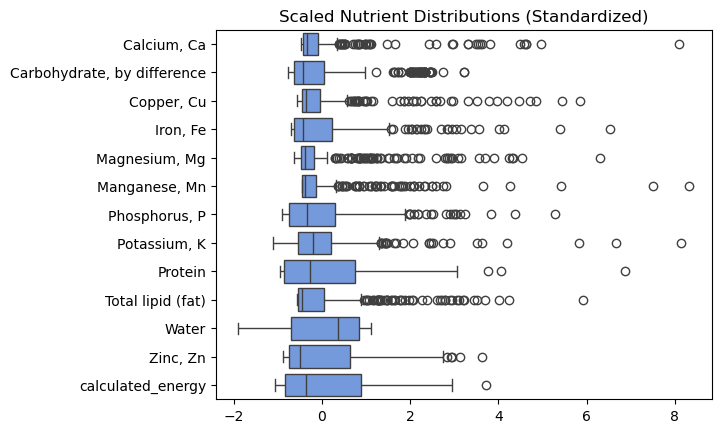

In [107]:
from sklearn.preprocessing import StandardScaler
import math
import scipy.stats as stats


nutrient_cols = foods.drop(columns=['fdc_id', 'description', 'food_category']).columns

scaled = pd.DataFrame(
    StandardScaler().fit_transform(foods[nutrient_cols]),
    columns=nutrient_cols
)

sns.boxplot(data=scaled, orient='h', color='cornflowerblue')
plt.title('Scaled Nutrient Distributions (Standardized)')
plt.show()

C:\Users\Pichau\AppData\Local\Temp\ipykernel_11980\1410319347.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(summary_df['Nutrient'], rotation=75, ha='right')


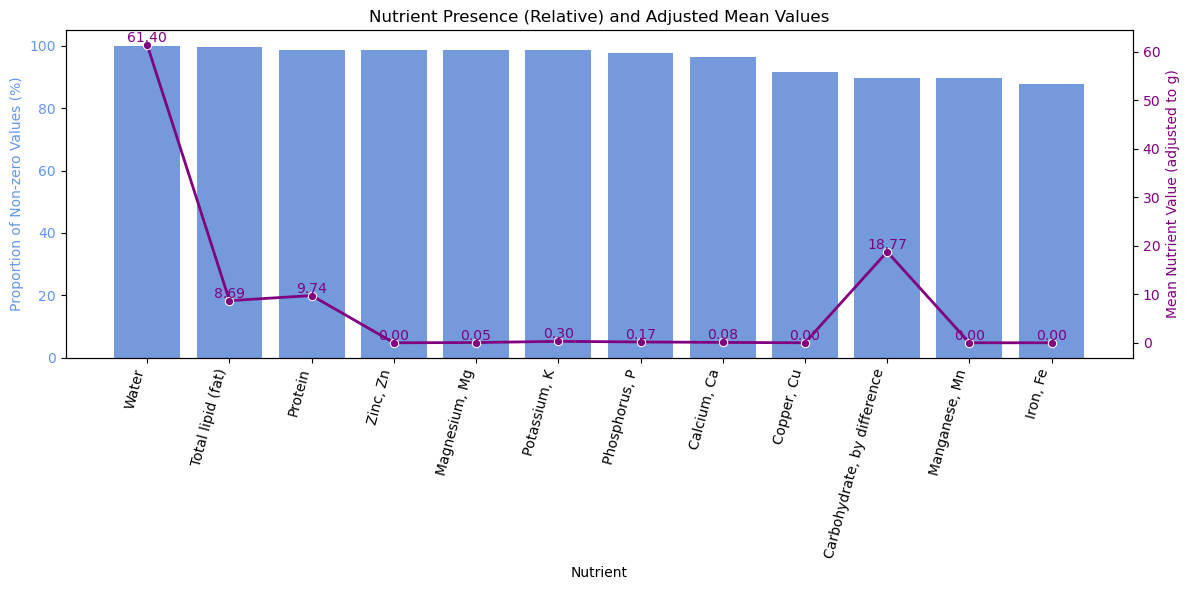

In [108]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# Columns that are nutrients
nutrient_cols = foods.drop(columns=['fdc_id', 'description', 'food_category', 'calculated_energy']).columns

non_zero_ratio = (foods[nutrient_cols] != 0).sum() / len(foods) * 100

# Mean values of nutrients
mean_values = foods[nutrient_cols].mean()

#  Convert specific nutrients from mg to g for better visualization
to_convert = ['Potassium, K', 'Phosphorus, P', 'Magnesium, Mg', 'Calcium, Ca', 'Manganese, Mn', 'Iron, Fe', 'Zinc, Zn', 'Copper, Cu']
for nut in to_convert:
    if nut in mean_values.index:
        mean_values.loc[nut] = mean_values.loc[nut] / 1000

# Create summary DataFrame
summary_df = pd.DataFrame({
    'Nutrient': nutrient_cols,
    'Non-zero Ratio': non_zero_ratio.values,
    'Mean Value': mean_values.values
})

# Sort by Non-zero Ratio descending
summary_df = summary_df.sort_values('Non-zero Ratio', ascending=False).reset_index(drop=True)

# --- Plot ---
fig, ax1 = plt.subplots(figsize=(12,6))

# Bars proportion of non-zero values
bar_colors = 'cornflowerblue'
sns.barplot(
    data=summary_df,
    x='Nutrient',
    y='Non-zero Ratio',
    color=bar_colors,
    ax=ax1
)
ax1.set_xlabel('Nutrient')
ax1.set_ylabel('Proportion of Non-zero Values (%)', color=bar_colors)
ax1.tick_params(axis='y', labelcolor=bar_colors)
ax1.set_xticklabels(summary_df['Nutrient'], rotation=75, ha='right')

# Line mean nutrient values
line_color = 'purple'
ax2 = ax1.twinx()
sns.lineplot(
    data=summary_df,
    x=range(len(summary_df)),        # usar posições numéricas para alinhar corretamente
    y='Mean Value',
    marker='o',
    linewidth=2,
    sort=False,                      # evita reorder automático por x
    ax=ax2,
    color=line_color
)
ax2.set_ylabel('Mean Nutrient Value (adjusted to g)', color=line_color)
ax2.tick_params(axis='y', labelcolor=line_color)

# Adicionar labels numéricos sobre cada ponto da linha (posicionamento com base nas posições numéricas)
for idx, val in enumerate(summary_df['Mean Value']):
    ax2.text(
        idx, val,
        f"{val:.2f}",
        color=line_color,
        ha='center',
        va='bottom',
        fontsize=10,
        rotation=0
    )

# Criar legenda manual (proxy artists) e posicionar no topo direito
bar_proxy = Patch(color='cornflowerblue', label='Proportion of Non-zero Values')
line_proxy = Line2D([0], [0], color='darkorange', marker='o', label='Mean Value (g)')

plt.title('Nutrient Presence (Relative) and Adjusted Mean Values')
plt.tight_layout()
plt.show()

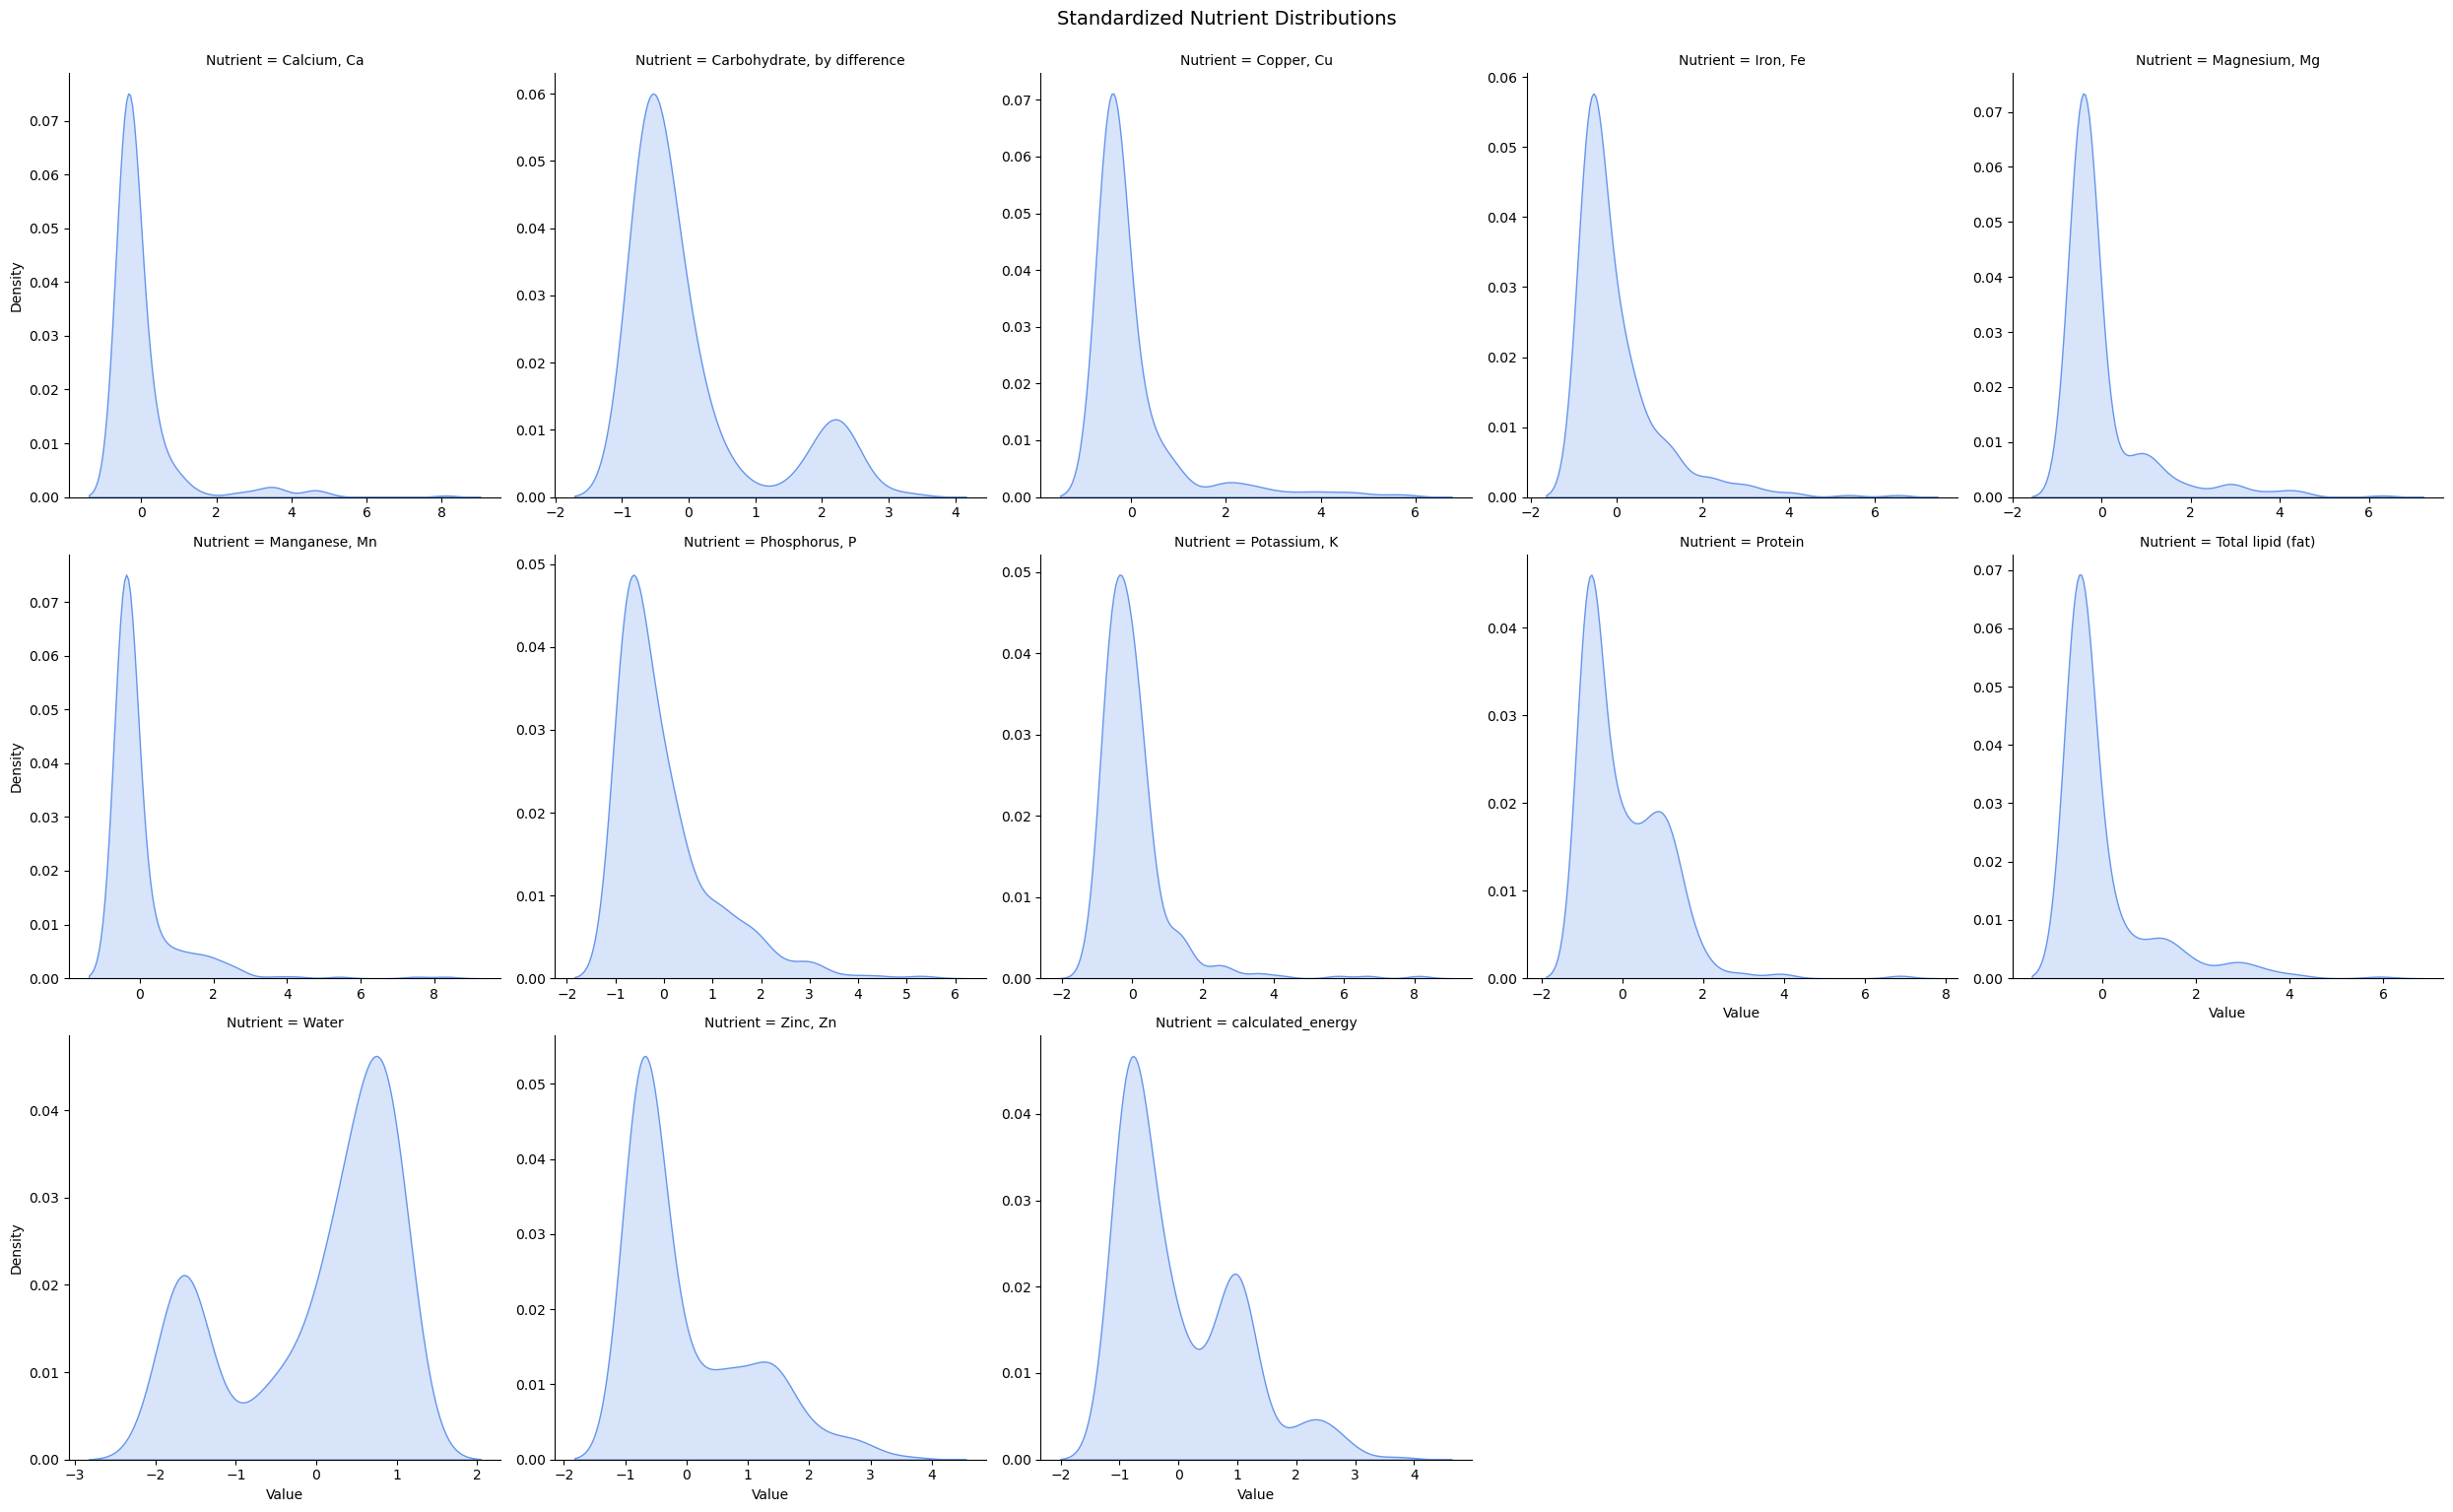

In [109]:
# Transform data to long format for Seaborn
df_melt = scaled.melt(var_name='Nutrient', value_name='Value')

# Create one distribution plot per nutrient
sns.displot(
    data=df_melt,
    x='Value',
    col='Nutrient',
    col_wrap=5, 
    kind='kde',  
    fill=True,
    facet_kws={'sharex': False, 'sharey': False},
    color='cornflowerblue'
)

plt.suptitle('Standardized Nutrient Distributions', y=1.02, fontsize=14)
plt.show()

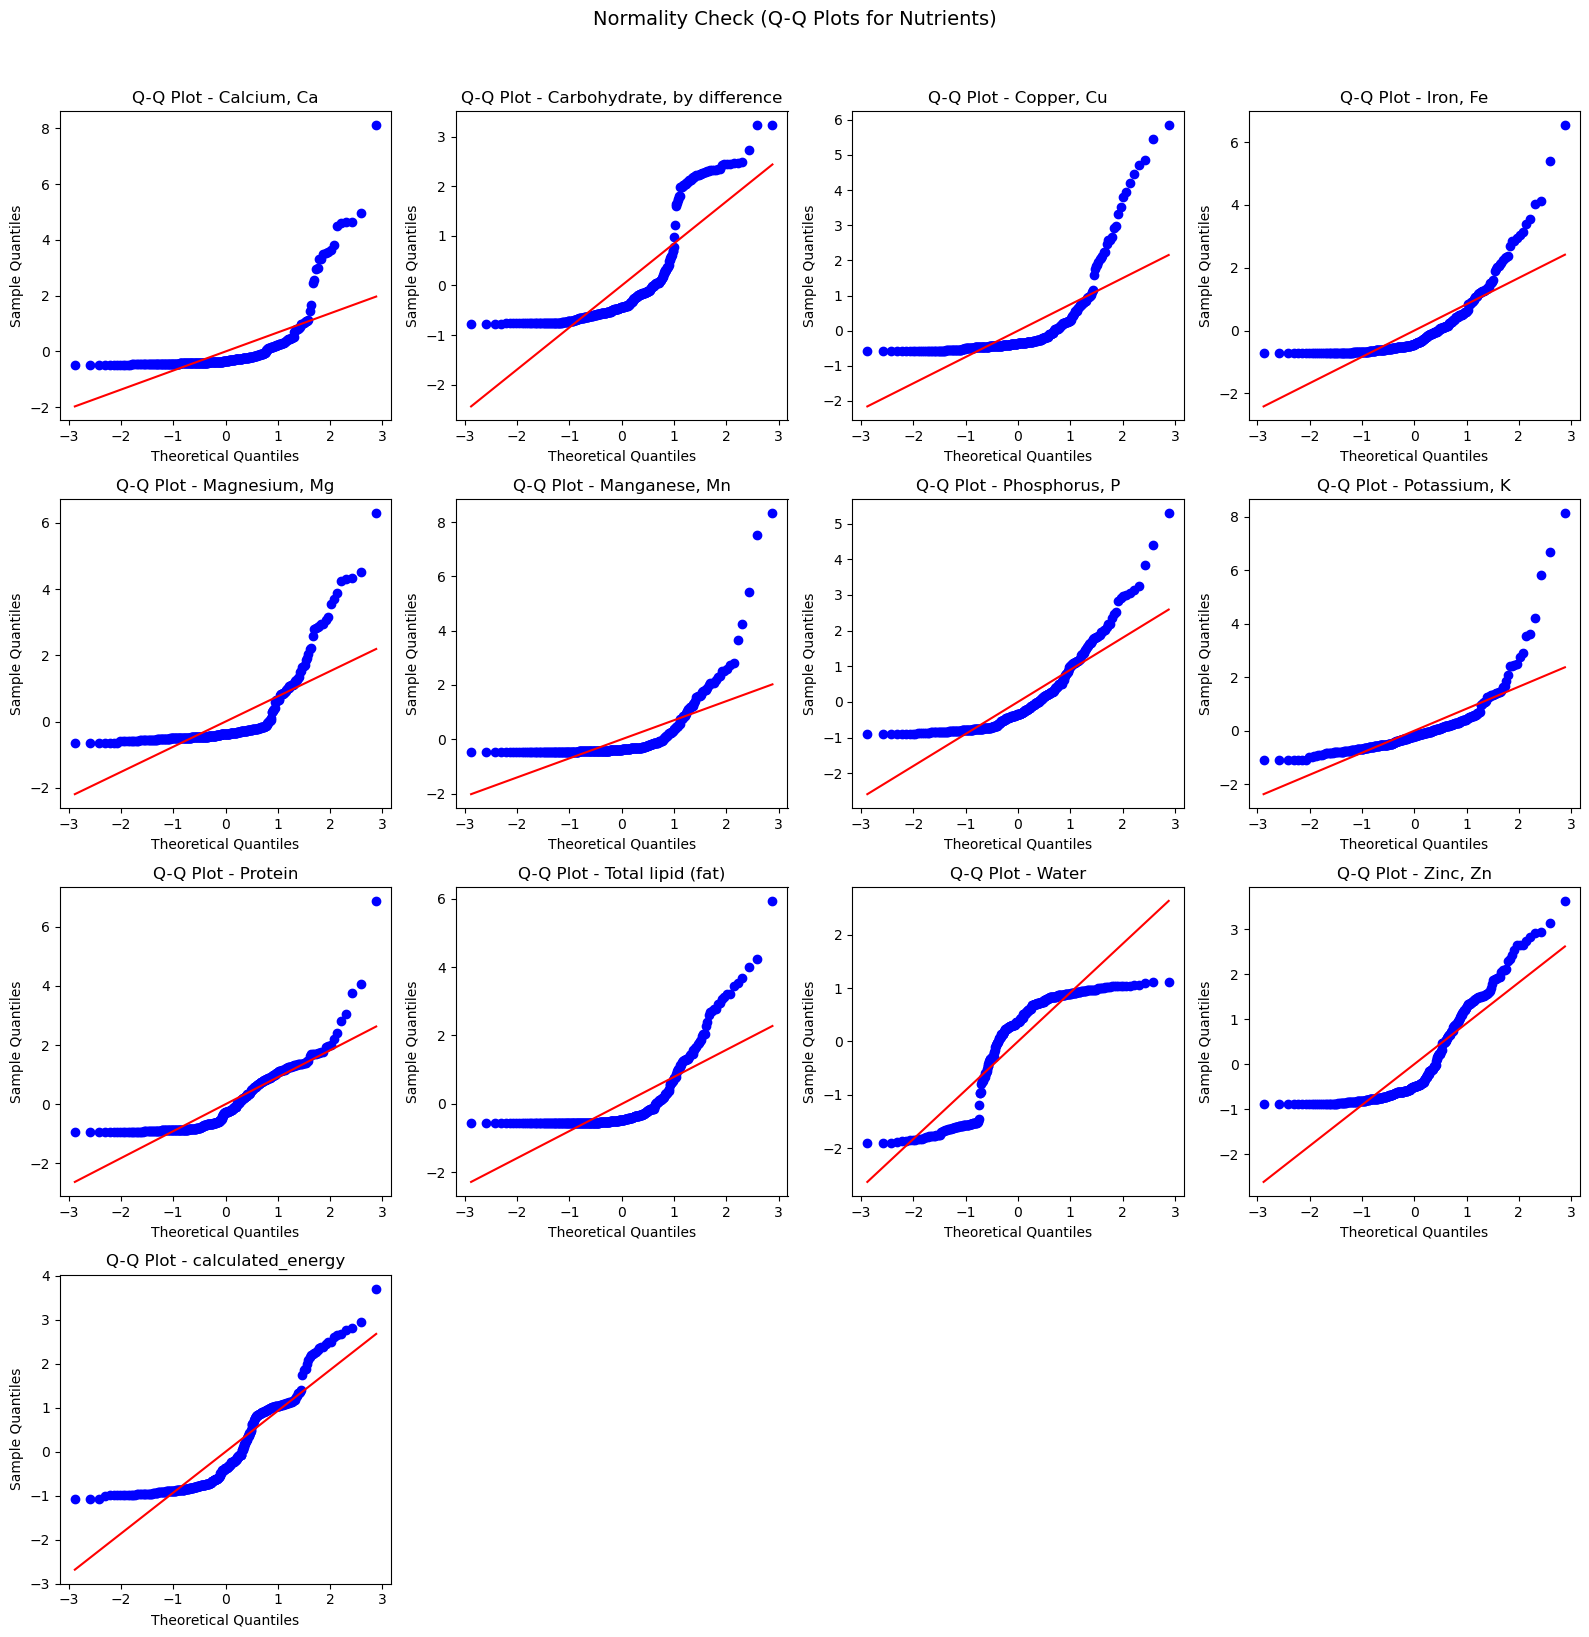

In [110]:
# Select scaled numeric columns
data = scaled.copy()  # from your StandardScaler step

# Create subplots dynamically
n_cols = 4
n_rows = math.ceil(len(data.columns) / n_cols)

plt.figure(figsize=(16, 4 * n_rows))

for i, col in enumerate(data.columns, 1):
    plt.subplot(n_rows, n_cols, i)
    stats.probplot(data[col], dist='norm', plot=plt)
    plt.title(f'Q-Q Plot - {col}')
    plt.xlabel('Theoretical Quantiles')
    plt.ylabel('Sample Quantiles')

plt.suptitle('Normality Check (Q-Q Plots for Nutrients)', y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

In [111]:
from scipy.stats import shapiro

for col in data.columns:
    stat, p = shapiro(data[col])
    print(f'{col}: p-value = {p:.4f}')

Calcium, Ca: p-value = 0.0000
Carbohydrate, by difference: p-value = 0.0000
Copper, Cu: p-value = 0.0000
Iron, Fe: p-value = 0.0000
Magnesium, Mg: p-value = 0.0000
Manganese, Mn: p-value = 0.0000
Phosphorus, P: p-value = 0.0000
Potassium, K: p-value = 0.0000
Protein: p-value = 0.0000
Total lipid (fat): p-value = 0.0000
Water: p-value = 0.0000
Zinc, Zn: p-value = 0.0000
calculated_energy: p-value = 0.0000


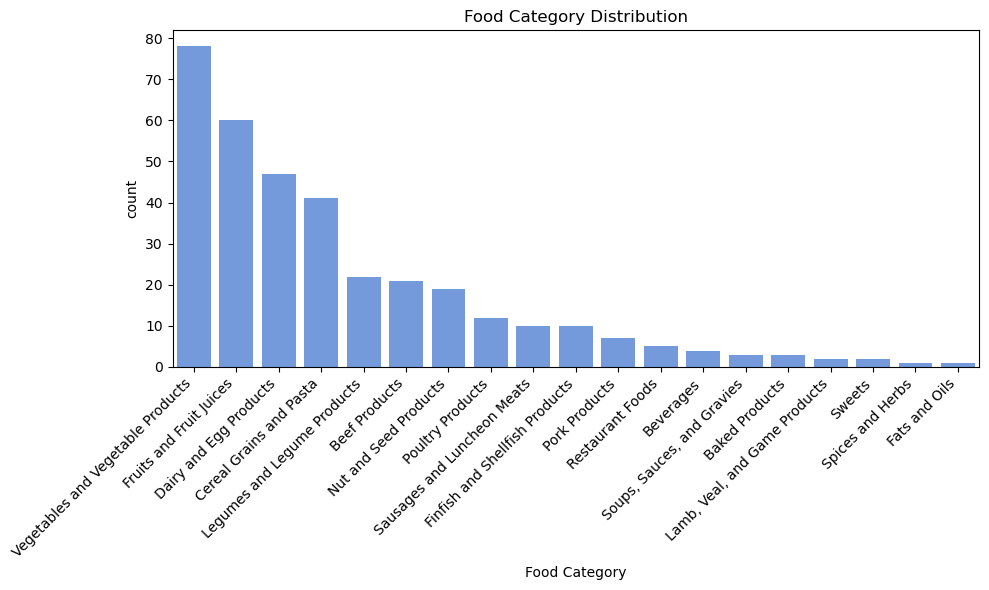

In [112]:
plt.figure(figsize=(10, 6))

sns.countplot(
    data=foods,
    x='food_category',
    order=foods['food_category'].value_counts().index,
    color='cornflowerblue'
)
plt.title('Food Category Distribution')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Food Category')
plt.tight_layout()
plt.show()

Conclusion:

- Normality is not a concern for predictive regression as long as the data is normalized/scaled.
- Additional transformations can improve stability and interpretability of linear models, but they are not mandatory.
- For tree-based or ensemble methods, non-normality does not pose any issues.

#### Bivariate Analysis

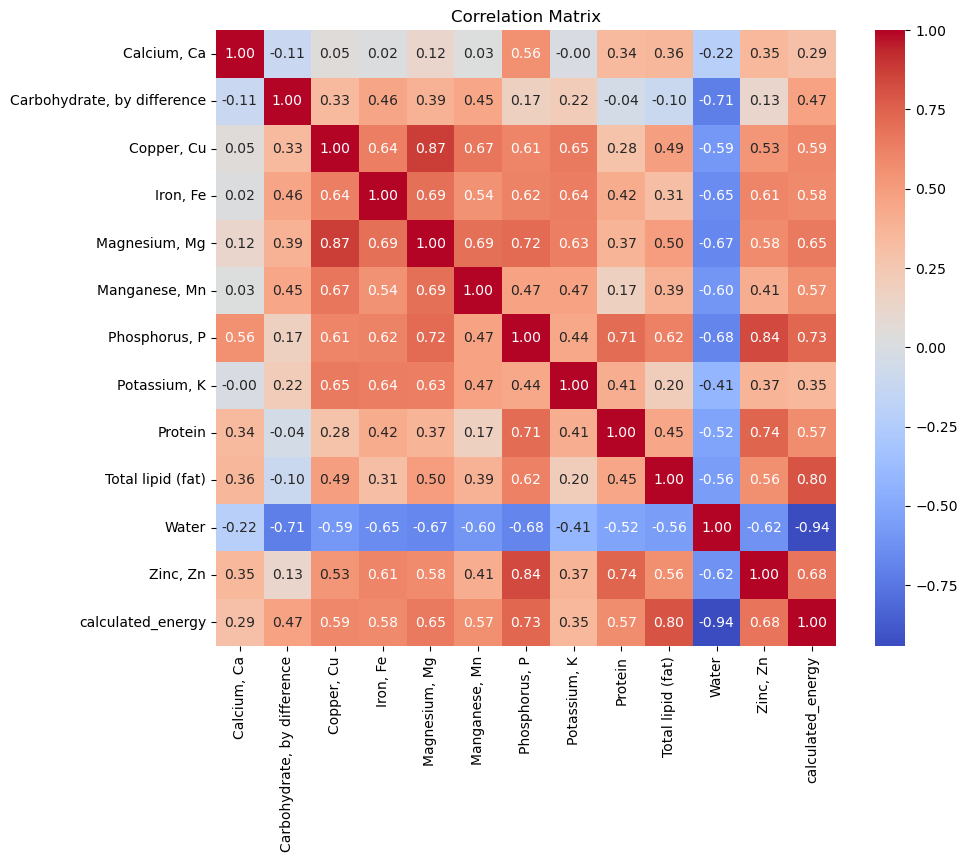

In [113]:
corr_matrix = scaled.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix')
plt.show()

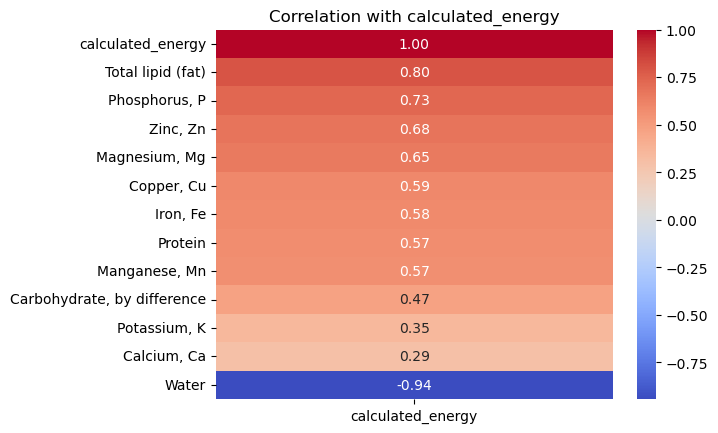

In [114]:
target =  'calculated_energy'
correlations = scaled.corr()[target].sort_values(ascending=False)

sns.heatmap(correlations.to_frame(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title(f'Correlation with {target}')
plt.show()

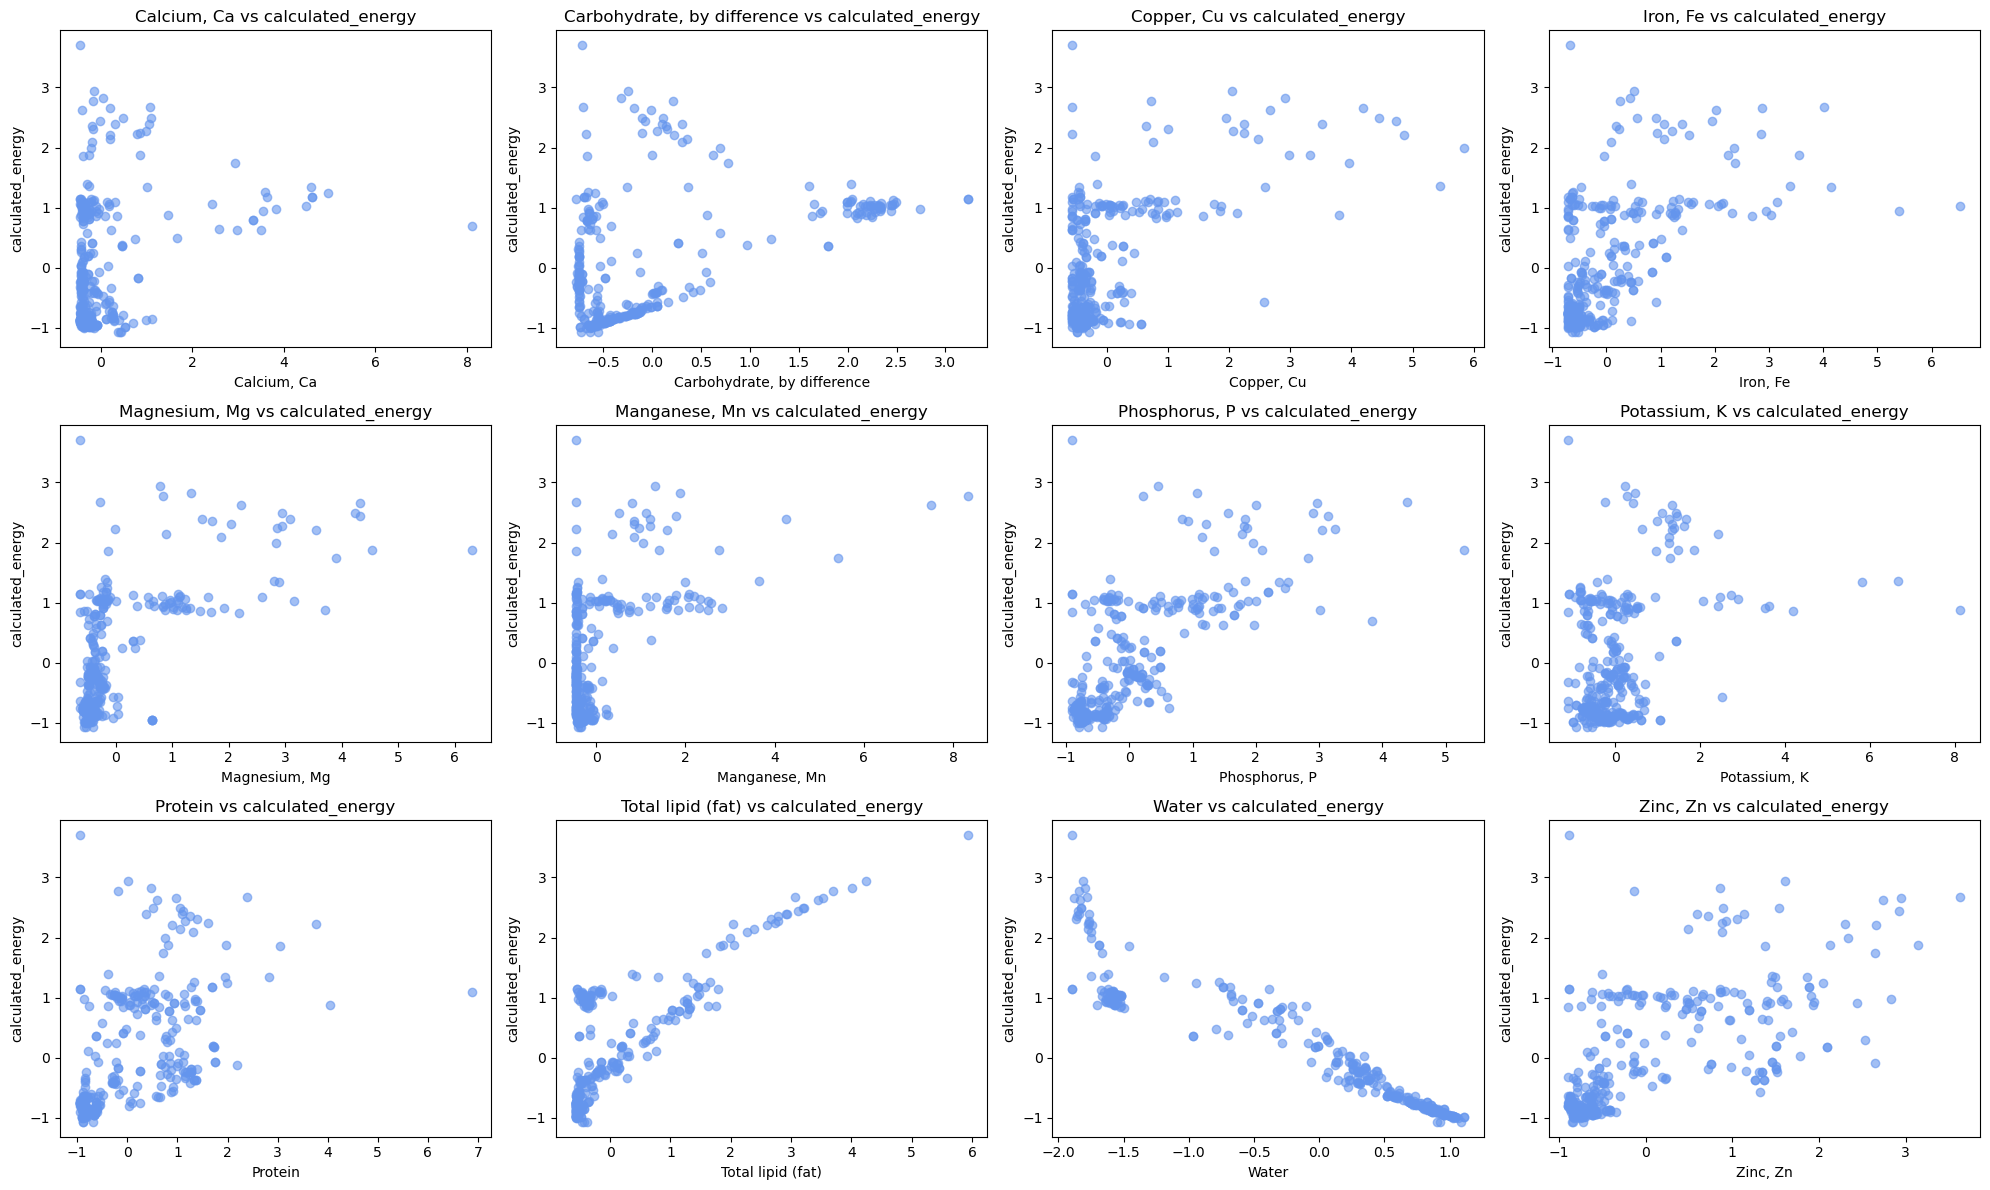

In [115]:
target =  'calculated_energy'
features = [col for col in scaled.columns if col != target]

n_cols = 4
n_rows = math.ceil(len(features) / n_cols) # number of rows needed

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*5, n_rows*4))
axes = axes.flatten()  # Flatten in case of multiple rows

for i, feature in enumerate(features):
    axes[i].scatter(scaled[feature], scaled[target], color='cornflowerblue', alpha=0.6)
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel(target)
    axes[i].set_title(f'{feature} vs {target}')

plt.tight_layout()
plt.show()

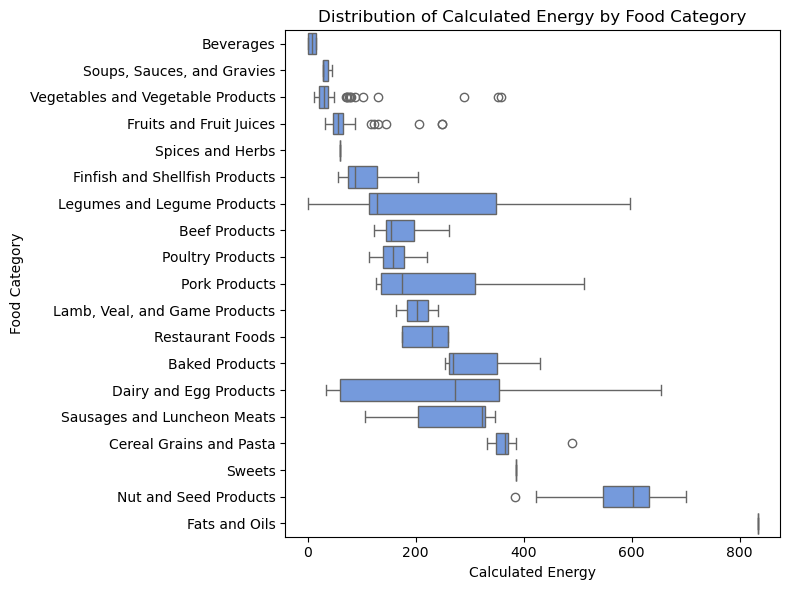

In [116]:
plt.figure(figsize=(8,6))

order = (
    foods.groupby('food_category')['calculated_energy']
    .median()
    .sort_values(ascending=True)
    .index
)

sns.boxplot(y='food_category', x='calculated_energy', data=foods, color='cornflowerblue', order=order)
plt.title('Distribution of Calculated Energy by Food Category')
plt.ylabel('Food Category')
plt.xlabel('Calculated Energy')
plt.tight_layout()
plt.show()

#### Dataset Observations

- There is a wide range of ``calculated_energy`` values across different food categories, with some categories (e.g., 'Fats and Oils', 'Nut and Seed Products') showing much higher energy content than others (e.g., 'Vegetables and Vegetable Products', 'Soups, Sauces, and Gravies').
- Several features exhibit strong variability, suggesting a heterogeneous dataset with foods differing substantially in nutritional composition.

- The heatmap confirms the strongest correlations with ``calculated_energy`` are:
  - **Total lipid (fat) (0.80)** → high impact
  - **Water (-0.94)** → negative impact
  - **Phosphorus (0.73), Magnesium (0.65), Zinc (0.68)** → moderate positive impact

- Features like Carbohydrate (0.47) and Protein (0.57) have moderate positive influence.
- Overall, energy content is largely driven by fat and water content, with other nutrients providing secondary contributions.

#### Modeling Implications

- Features with **strong correlations** (``Total lipid``, ``Water``) are likely the *most predictive for regression models* targeting ``calculated_energy``.
- Outliers in energy-rich categories (e.g., ``Fats and Oils``) should be considered for *robust regression or transformation*.
- Features with weak correlation can be *candidates for exclusion* or given lower importance in tree-based models.

---
## ML Model

In [117]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error
from sklearn.linear_model import LinearRegression

target = 'calculated_energy'
features = foods.drop(columns=['fdc_id', 'description', target]).columns

X_train, X_test, y_train, y_test = train_test_split(
    foods[features],
    foods[target],
    test_size=0.2,
    random_state=42)


### Aux Functions

In [118]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    metrics = {
        'MSE': mean_squared_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'R2': r2_score(y_test, y_pred)
    }
    return metrics

In [119]:
def display_metrics(metrics, title=None):
    if title:
        print(title)
    print('Model Evaluation Metrics:')
    for name, value in metrics.items():
        print(f'{name}: {value:.4f}')

### Pipeline

In [120]:
# Identify categorical and numerical columns
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Preprocessing for numerical and categorical data
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Create a pipeline that first preprocesses the data and then fits a model
pipeline_lr = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Another pipeline with RandomForestRegressor
pipeline_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Train the models
pipeline_lr.fit(X_train, y_train)
pipeline_rf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Calcium, Ca',
                                                   'Carbohydrate, by '
                                                   'difference',
                                                   'Copper, Cu', 'Iron, Fe',
                                                   'Magnesium, Mg',
                                                   'Manganese, Mn',
                                                   'Phosphorus, P',
                                                   'Potassium, K', 'Protein',
                                                   'Total lipid (fat)', 'Water',
                                                   'Zinc, Zn']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['food_category'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

In [121]:
eval_lr = evaluate_model(pipeline_lr, X_test, y_test)
eval_rf = evaluate_model(pipeline_rf, X_test, y_test)

display_metrics(eval_lr, title='Linear Regression Performance')
print('\n' + '='*50 + '\n')
display_metrics(eval_rf, title='Random Forest Performance')

Linear Regression Performance
Model Evaluation Metrics:
MSE: 32.0826
RMSE: 5.6642
R2: 0.9989


Random Forest Performance
Model Evaluation Metrics:
MSE: 746.9453
RMSE: 27.3303
R2: 0.9749


In [122]:
# evaliation for train set
eval_train_lr = evaluate_model(pipeline_lr, X_train, y_train)
eval_train_rf = evaluate_model(pipeline_rf, X_train, y_train)

display_metrics(eval_train_lr, title='Linear Regression on Train Set Performance')
print('\n' + '='*50 + '\n')
display_metrics(eval_train_rf, title='Random Forest on Train Set Performance')

Linear Regression on Train Set Performance
Model Evaluation Metrics:
MSE: 36.9112
RMSE: 6.0755
R2: 0.9988


Random Forest on Train Set Performance
Model Evaluation Metrics:
MSE: 53.7037
RMSE: 7.3283
R2: 0.9982


In [123]:
X = foods[features]
y = foods[target]

# ===== Cross-validation with R² =====
cv_scores_lr = cross_val_score(pipeline_lr, X, y, cv=5, scoring='r2')
cv_scores_rf = cross_val_score(pipeline_rf, X, y, cv=5, scoring='r2')

print('\n=== Cross-Validation (5 folds) ===')
print(f'Linear Regression -> Média R²: {cv_scores_lr.mean():.4f} ± {cv_scores_lr.std():.4f}')
print(f'Random Forest     -> Média R²: {cv_scores_rf.mean():.4f} ± {cv_scores_rf.std():.4f}')


=== Cross-Validation (5 folds) ===
Linear Regression -> Média R²: 0.9973 ± 0.0009
Random Forest     -> Média R²: 0.9882 ± 0.0055


In [124]:
# Saving pipelines
joblib.dump(pipeline_lr, 'models/linear_regression_pipeline.pkl')
joblib.dump(pipeline_rf, 'models/random_forest_pipeline.pkl')

['models/random_forest_pipeline.pkl']

### Hyperparameter Tuning with GridSearchCV

In [125]:
# Parameter grid for RandomForestRegressor
param_grid = {
    'regressor__n_estimators': [100, 200, 500],
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4],
    'regressor__max_features': ['sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=pipeline_rf,
    param_grid=param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['Calcium, '
                                                                          'Ca',
                                                                          'Carbohydrate, '
                                                                          'by '
                                                                          'difference',
                                                                          'Copper, '
                                                                          'Cu',
                                                                          'Iron, '
                                                                          'Fe',
                                                                          'Magnesium, '
                                                                          'Mg',
                                                                          'Manganese, '
                                                                          'Mn',
                                                                          'Phosphorus, '
                                                                          'P',
                                                                          'Potassium, '
                                                                          'K',
                                                                          'Protein',
                                                                          'Total '
                                                                          'lipid '
                                                                          '(fat)',
                                                                          'Water',
                                                                          'Zinc, '
                                                                          'Zn']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['food_category'])])),
                                       ('regressor',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'regressor__max_depth': [None, 10, 20, 30],
                         'regressor__max_features': ['sqrt', 'log2'],
                         'regressor__min_samples_leaf': [1, 2, 4],
                         'regressor__min_samples_split': [2, 5, 10],
                         'regressor__n_estimators': [100, 200, 500]},
             scoring='r2', verbose=2)

In [126]:
# best model and parameters
best_rf_model = grid_search.best_estimator_
best_params = grid_search.best_params_

print('Best Hyperparameters for Random Forest:')
for param, value in best_params.items():
    print(f'{param}: {value}')

print('\n' + '='*50 + '\n')
eval_best_rf = evaluate_model(best_rf_model, X_test, y_test)
display_metrics(eval_best_rf, title='Best Random Forest Model Performance')

Best Hyperparameters for Random Forest:
regressor__max_depth: 10
regressor__max_features: sqrt
regressor__min_samples_leaf: 1
regressor__min_samples_split: 2
regressor__n_estimators: 500


Best Random Forest Model Performance
Model Evaluation Metrics:
MSE: 1415.4314
RMSE: 37.6222
R2: 0.9525


In [127]:
# saving the best model
joblib.dump(best_rf_model, 'models/best_random_forest_pipeline.pkl')

['models/best_random_forest_pipeline.pkl']

GridSearchCV did not improve the model's performance because the default RandomForestRegressor parameters were already well-suited for the dataset, and the hyperparameter space explored did not yield significantly better combinations. 

The model may have reached its optimal performance given the features and data quality, so further tuning had little effect. Additionally, Random Forests are robust to parameter changes, and the dataset may not have enough complexity or noise for hyperparameter optimization to make a noticeable difference.

### Feature Importance

In [128]:
def plot_feature_importance(model, feature_names, model_name='Model'):
    """
    Plots feature importance for tree-based models or feature coefficients for linear models.
    """
    # Try to get feature importances
    try:
        # For tree-based models
        importances = model.named_steps['regressor'].feature_importances_
    except AttributeError:
        # For linear models
        importances = model.named_steps['regressor'].coef_
    
    # Take absolute values for linear models (importance magnitude)
    importances = np.abs(importances)
    
    # Create a DataFrame
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)
    
    # Plotting
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df, color='cornflowerblue')
    plt.title(f'Feature Importances from {model_name}')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()


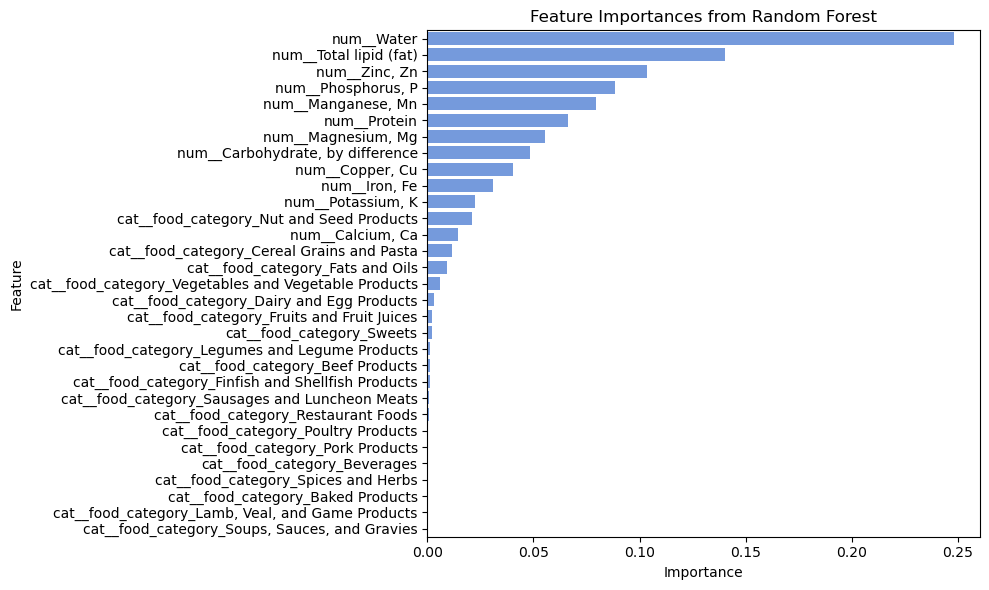

In [129]:
# Plot feature importances
plot_feature_importance(best_rf_model, preprocessor.get_feature_names_out(), 'Random Forest')

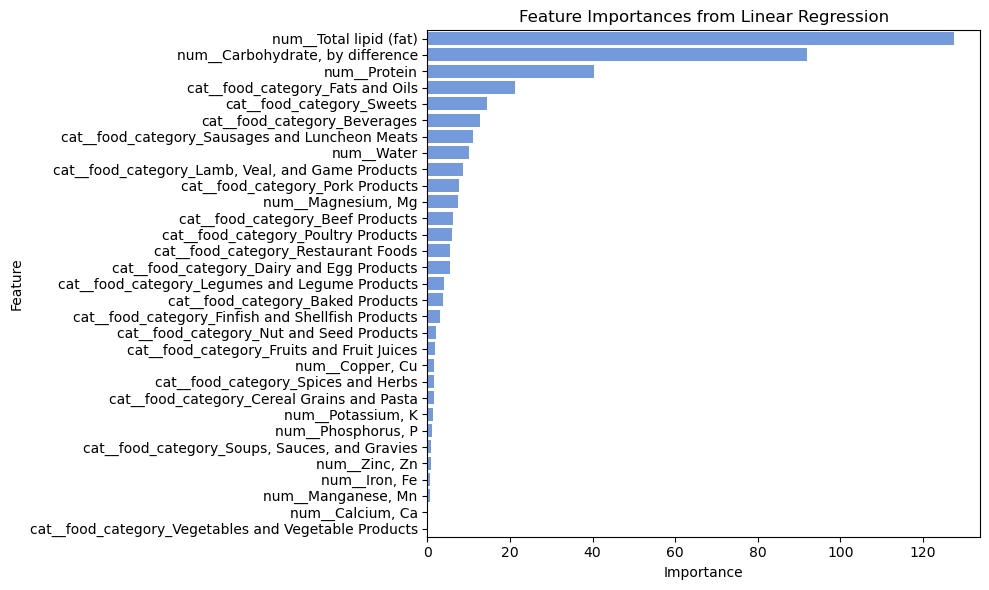

In [130]:
# Plot feature importances
plot_feature_importance(pipeline_lr, preprocessor.get_feature_names_out(), 'Linear Regression')

The Importance plots reveal the following insights regarding `calculated_energy`:

- **Top contributing features:**
  - **Total lipid (fat)**
  - **Carbohydrates (by difference)**
  - **Protein**

  These are expected to be the most influential, as `calculated_energy` is directly derived from these macronutrients.

- **Other observations:**
  - **Water** also shows some importance. This is primarily because it does **not contribute to energy**, resulting in a negative relationship with total energy.

> **Insight:** The model correctly identifies the main energy-providing nutrients, while also recognizing features that inversely affect energy.


---
### Minimal features Model

What if we remove the features used to calculate `calculated_energy`?

As we saw in the previous model and analysis, the variables used to compute `calculated_energy` were highly influential in achieving the model's high predictive performance. 

But what if we didn't have access to these variables? Which features would then emerge as the most important?

In [131]:
target = 'calculated_energy'
features = foods.drop(columns=['fdc_id', 'description', 'Carbohydrate, by difference','Protein', 'Total lipid (fat)', target]).columns

X_train, X_test, y_train, y_test = train_test_split(
    foods[features],
    foods[target],
    test_size=0.2,
    random_state=42)

In [132]:
# Identify categorical and numerical columns
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Create a pipeline that first preprocesses the data
pipeline_lr_mf = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Another pipeline with RandomForestRegressor
pipeline_rf_mf = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=500, random_state=42, max_depth=10))
])

In [133]:
# Train the models
pipeline_lr_mf.fit(X_train, y_train)
pipeline_rf_mf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Calcium, Ca', 'Copper, Cu',
                                                   'Iron, Fe', 'Magnesium, Mg',
                                                   'Manganese, Mn',
                                                   'Phosphorus, P',
                                                   'Potassium, K', 'Water',
                                                   'Zinc, Zn']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['food_category'])])),
                ('regressor',
                 RandomForestRegressor(max_depth=10, n_estimators=500,
                                       random_state=42))])

In [134]:
eval_lr_mf = evaluate_model(pipeline_lr_mf, X_test, y_test)
eval_rf_mf = evaluate_model(pipeline_rf_mf, X_test, y_test)

display_metrics(eval_lr_mf, title='Linear Regression MF Performance')
print('\n' + '='*50 + '\n')
display_metrics(eval_rf_mf, title='Random Forest MF Performance')


Linear Regression MF Performance
Model Evaluation Metrics:
MSE: 1052.2340
RMSE: 32.4382
R2: 0.9647


Random Forest MF Performance
Model Evaluation Metrics:
MSE: 1296.9588
RMSE: 36.0133
R2: 0.9564


In [135]:
# saving pipelines for mininal features
joblib.dump(pipeline_lr_mf, 'models/linear_regression_minimal_features_pipeline.pkl')
joblib.dump(pipeline_rf_mf, 'models/random_forest_minimal_features_pipeline.pkl')

['models/random_forest_minimal_features_pipeline.pkl']

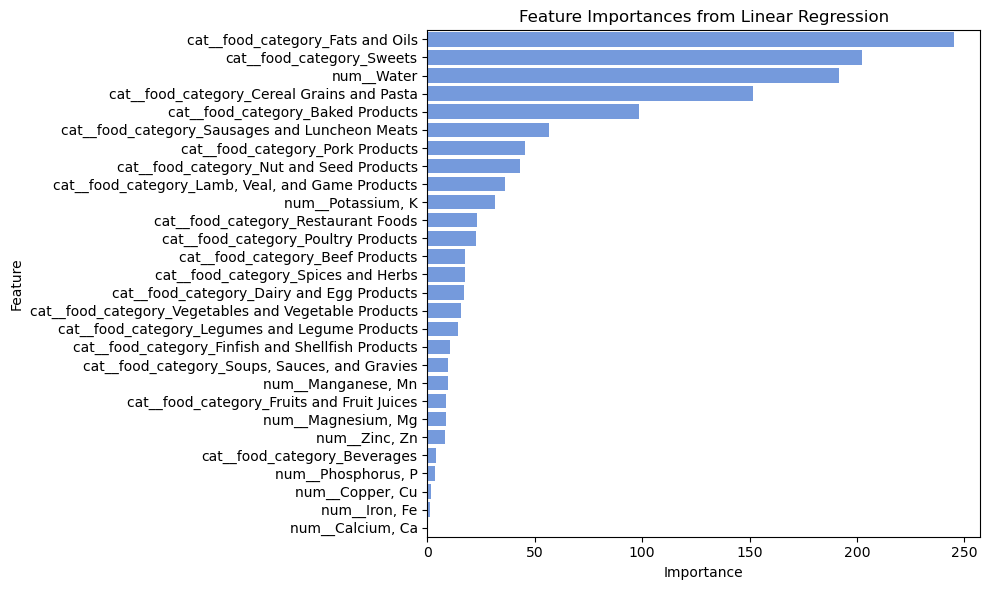

In [136]:
# Plot feature importances
plot_feature_importance(pipeline_lr_mf, preprocessor.get_feature_names_out(), 'Linear Regression')

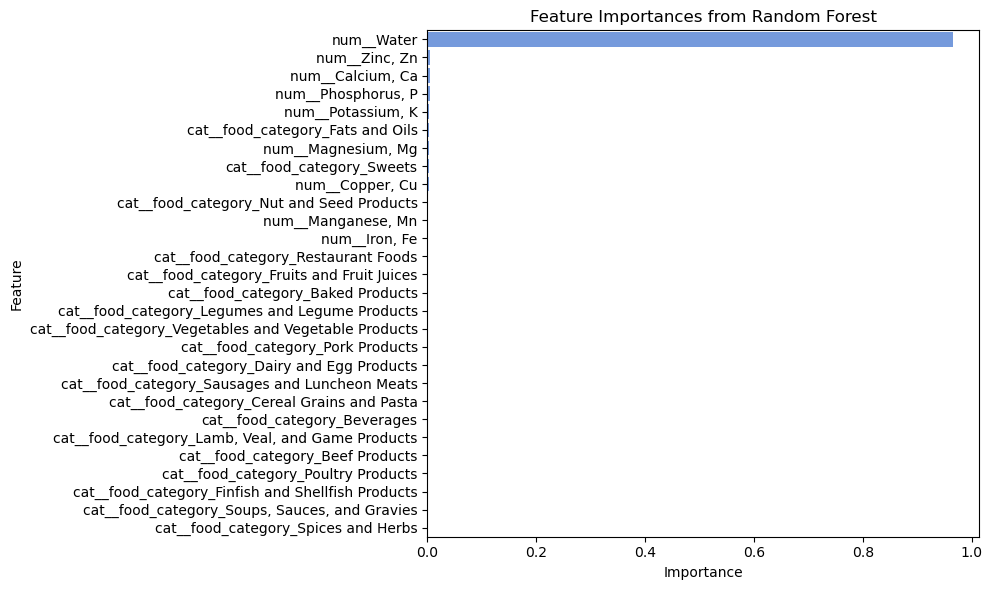

In [137]:
# Plot feature importances
plot_feature_importance(pipeline_rf_mf, preprocessor.get_feature_names_out(), 'Random Forest')

Water is the dominant feature because it has an extremely strong negative correlation with calculated_energy (r = -0.94). Since calculated_energy is expressed per 100 g, higher water content effectively dilutes energy-dense macronutrients (fat, protein, carbohydrates). As water increases, the concentration of those energy-providing nutrients drops, so energy per 100 g falls — creating a near-deterministic inverse relationship that a Random Forest easily exploits.

- Model implications: Feature importance in Random Forest reflects how much a feature reduces impurity; a feature like water with a stable, strong relationship will dominate importance scores.

---
## Conclusions


Following the CRISP-DM framework, this project successfully explored and modeled the nutritional data from the FoodData Central Foundation dataset. 
The analysis addressed the main business questions proposed in the introduction, offering quantitative and visual insights into nutrient composition and their contribution to total energy.

**1. Most Common Nutrients**

The most frequent nutrients identified across food items included *Protein*, *Total lipid (fat)*, *Carbohydrate, by difference*, *Water*, *Potassium*, and *Phosphorus*. 
These nutrients are the fundamental macronutrients and minerals consistently present in most food entries, confirming the database’s nutritional consistency and coverage.

**2. Variation Across Food Categories**

Exploratory visualizations, including boxplots and category-based comparisons, revealed distinct nutrient distributions across food categories. 
For example, *dairy* and *meat* products showed higher protein and fat contents, whereas *fruits* and *vegetables* had higher water and lower energy density. This differentiation reinforces the categorical grouping’s validity and helps characterize foods according to their nutritional profiles.

**3. Nutrients Contributing Most to Total Energy**

Feature importance analysis using a Random Forest and Linear Regression models demonstrated that *Total lipid (fat)*, *Carbohydrate, by difference*, and *Protein* are the dominant predictors of `calculated_energy`. This aligns with the theoretical basis of energy calculation, where fat contributes 9 kcal/g and carbohydrates and protein contribute 4 kcal/g.

When those atributtes are removed from the analysis, the Linear Regression Model shows the importance of the categorical labels. Where *Fats and Oils* contribues the most with the target.Interestingly, *Water* also showed relevance in the negative direction, reflecting its dilution effect on energy content.

**4. Model Evaluation and Interpretation**

The Random Forest regressor performed consistently, capturing non-linear relationships between nutrients and total energy. Feature importance analysis validated the model’s interpretability, showing that the predicted energy increases with higher values of fat and carbohydrates, while foods with higher water content tend to have lower energy values. The model’s metrics indicated a strong predictive relationship, supporting its reliability for nutritional estimation tasks.


### Additional Findings
Correlation analysis highlighted strong multicollinearity among macronutrients and energy, which is expected in compositional food data. The preprocessing pipeline effectively standardized and encoded features, ensuring the model could generalize across multiple food categories. Overall, the results confirmed that the FoodData Central dataset is suitable for predictive and exploratory nutritional studies.

---